In [1]:
!pip install xgboost
!pip install category_encoders
!pip install openpyxl
!pip install keras
!pip install tensorflow
!pip install scikeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import category_encoders as ce
from category_encoders import TargetEncoder
import warnings
import datetime
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
import datetime

# Custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        current_year = datetime.datetime.now().year
        X = X.copy()
        X['IDADE_IMOVEL'] = current_year - X['ANO_CONSTRUCAO']

        bins_abp = [0, 50, 100, 150, 200, np.inf]
        labels_abp = ['0-50', '51-100', '101-150', '151-200', '200+']
        X['ABP_BINNED'] = pd.cut(X['ABP'], bins=bins_abp, labels=labels_abp)

        X['LAT_LONG_INTERACTION'] = X['LATITUDE'] * X['LONGITUDE']

        bins_idade = [0, 10, 20, 50, 100, np.inf]
        labels_idade = ['0-10', '11-20', '21-50', '51-100', '100+']
        X['IDADE_GRUPO'] = pd.cut(X['IDADE_IMOVEL'], bins=bins_idade, labels=labels_idade)

        return X

# Custom transformer to ensure the output is a DataFrame
class EnsureDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

# Specify numeric and categorical features
numeric_features = ['N_QUARTOS', 'ABP', 'LATITUDE', 'LONGITUDE', 'ANO_CONSTRUCAO']
categorical_features = ['TIPO_IMOVEL', 'CCE', 'FREGUESIA', 'CP7', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ABP_BINNED', 'IDADE_GRUPO']

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that includes the custom feature engineering and the preprocessor
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),
    ('feature_selection', ColumnTransformer(
        transformers=[
            ('selected', 'passthrough', ['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])
        ], remainder='drop')),
    ('ensure_dataframe', EnsureDataFrame(columns=['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=1.0,
                               colsample_bytree=1.0, gamma=0, reg_lambda=5, random_state=42))
])

# Load your data
cubo_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\Cubo_202203_NOVAIMS_2022-05-13.xlsx")
year_construction_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\20220725_ano_construcao.xlsx")
merged_data = cubo_data.merge(year_construction_data, on='IMOVEL_ID', how='left')

# Remove rows with missing target
merged_data = merged_data.dropna(subset=['PRECO_VENDA_OBSERVADO'])

# Define feature matrix X and target vector y
X = merged_data.drop('PRECO_VENDA_OBSERVADO', axis=1)
y = merged_data['PRECO_VENDA_OBSERVADO']

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to hold the scores
train_mae_list = []
train_rmse_list = []
train_r2_list = []
test_mae_list = []
test_rmse_list = []
test_r2_list = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ensure X_train and X_test are DataFrames
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the training and testing data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate training metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate testing metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append the scores
    train_mae_list.append(train_mae)
    train_rmse_list.append(train_rmse)
    train_r2_list.append(train_r2)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    test_r2_list.append(test_r2)

# Calculate average metrics
avg_train_mae = np.mean(train_mae_list)
avg_train_rmse = np.mean(train_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_mae = np.mean(test_mae_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_r2 = np.mean(test_r2_list)

print("Average Train MAE:", avg_train_mae)
print("Average Train RMSE:", avg_train_rmse)
print("Average Train R2:", avg_train_r2)
print("Average Test MAE:", avg_test_mae)
print("Average Test RMSE:", avg_test_rmse)
print("Average Test R2:", avg_test_r2)



Average Train MAE: 29007.883822709824
Average Train RMSE: 46941.54386316503
Average Train R2: 0.9476822785556573
Average Test MAE: 47943.06722018165
Average Test RMSE: 100331.8090695918
Average Test R2: 0.7607523791498773


Average Train MAE: 29007.883822709824
Average Train RMSE: 46941.54386316503
Average Train R2: 0.9476822785556573
Average Test MAE: 47943.06722018165
Average Test RMSE: 100331.8090695918
Average Test R2: 0.7607523791498773


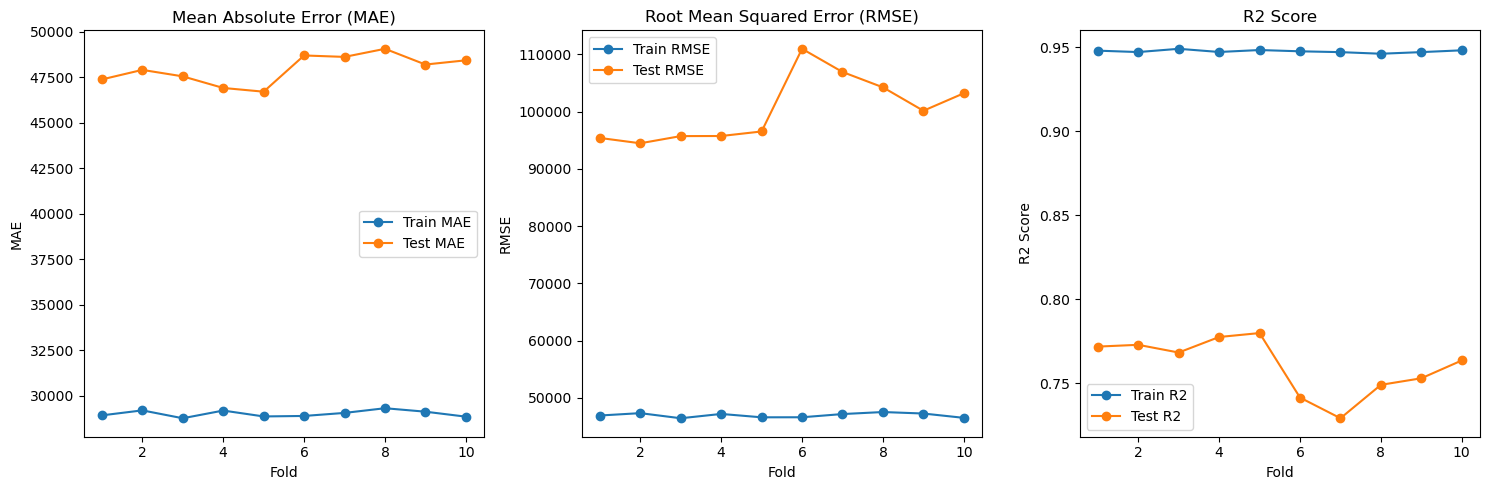

In [6]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
import datetime
import matplotlib.pyplot as plt

# Custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        current_year = datetime.datetime.now().year
        X = X.copy()
        X['IDADE_IMOVEL'] = current_year - X['ANO_CONSTRUCAO']

        bins_abp = [0, 50, 100, 150, 200, np.inf]
        labels_abp = ['0-50', '51-100', '101-150', '151-200', '200+']
        X['ABP_BINNED'] = pd.cut(X['ABP'], bins=bins_abp, labels=labels_abp)

        X['LAT_LONG_INTERACTION'] = X['LATITUDE'] * X['LONGITUDE']

        bins_idade = [0, 10, 20, 50, 100, np.inf]
        labels_idade = ['0-10', '11-20', '21-50', '51-100', '100+']
        X['IDADE_GRUPO'] = pd.cut(X['IDADE_IMOVEL'], bins=bins_idade, labels=labels_idade)

        return X

# Custom transformer to ensure the output is a DataFrame
class EnsureDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

# Specify numeric and categorical features
numeric_features = ['N_QUARTOS', 'ABP', 'LATITUDE', 'LONGITUDE', 'ANO_CONSTRUCAO']
categorical_features = ['TIPO_IMOVEL', 'CCE', 'FREGUESIA', 'CP7', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ABP_BINNED', 'IDADE_GRUPO']

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that includes the custom feature engineering and the preprocessor
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),
    ('feature_selection', ColumnTransformer(
        transformers=[
            ('selected', 'passthrough', ['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])
        ], remainder='drop')),
    ('ensure_dataframe', EnsureDataFrame(columns=['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=1.0,
                               colsample_bytree=1.0, gamma=0, reg_lambda=5, random_state=42))
])

# Load your data
cubo_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\Cubo_202203_NOVAIMS_2022-05-13.xlsx")
year_construction_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\20220725_ano_construcao.xlsx")
merged_data = cubo_data.merge(year_construction_data, on='IMOVEL_ID', how='left')

# Remove rows with missing target
merged_data = merged_data.dropna(subset=['PRECO_VENDA_OBSERVADO'])

# Define feature matrix X and target vector y
X = merged_data.drop('PRECO_VENDA_OBSERVADO', axis=1)
y = merged_data['PRECO_VENDA_OBSERVADO']

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to hold the scores
train_mae_list = []
train_rmse_list = []
train_r2_list = []
test_mae_list = []
test_rmse_list = []
test_r2_list = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ensure X_train and X_test are DataFrames
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the training and testing data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate training metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate testing metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append the scores
    train_mae_list.append(train_mae)
    train_rmse_list.append(train_rmse)
    train_r2_list.append(train_r2)
    test_mae_list.append(test_mae)
    test_rmse_list.append(test_rmse)
    test_r2_list.append(test_r2)

# Calculate average metrics
avg_train_mae = np.mean(train_mae_list)
avg_train_rmse = np.mean(train_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_mae = np.mean(test_mae_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_test_r2 = np.mean(test_r2_list)

print("Average Train MAE:", avg_train_mae)
print("Average Train RMSE:", avg_train_rmse)
print("Average Train R2:", avg_train_r2)
print("Average Test MAE:", avg_test_mae)
print("Average Test RMSE:", avg_test_rmse)
print("Average Test R2:", avg_test_r2)

# Plotting the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, kf.n_splits + 1), train_mae_list, label='Train MAE', marker='o')
plt.plot(range(1, kf.n_splits + 1), test_mae_list, label='Test MAE', marker='o')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, kf.n_splits + 1), train_rmse_list, label='Train RMSE', marker='o')
plt.plot(range(1, kf.n_splits + 1), test_rmse_list, label='Test RMSE', marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, kf.n_splits + 1), train_r2_list, label='Train R2', marker='o')
plt.plot(range(1, kf.n_splits + 1), test_r2_list, label='Test R2', marker='o')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.title('R2 Score')
plt.legend()

plt.tight_layout()
plt.show()


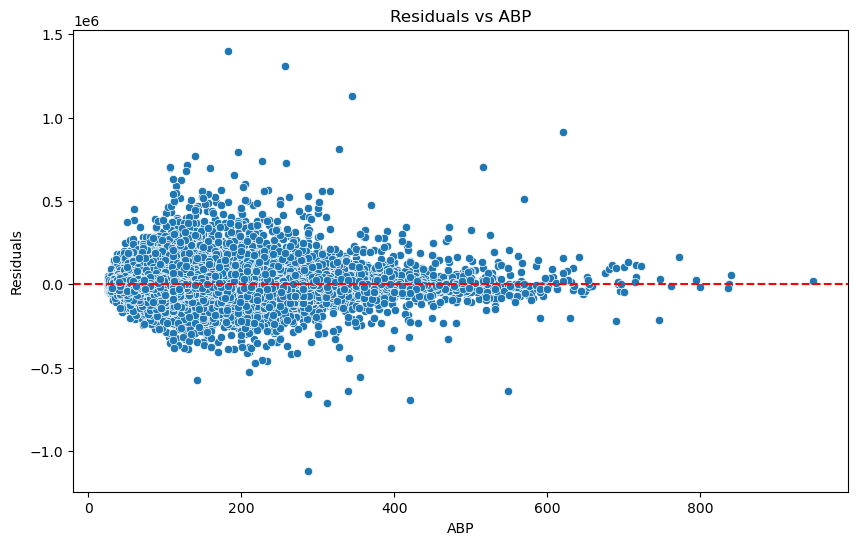

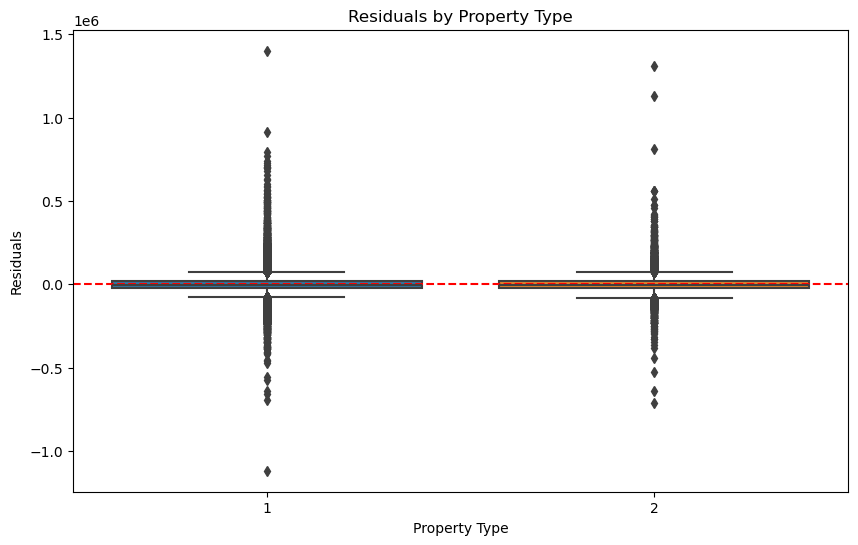

Recommendations based on the analysis:


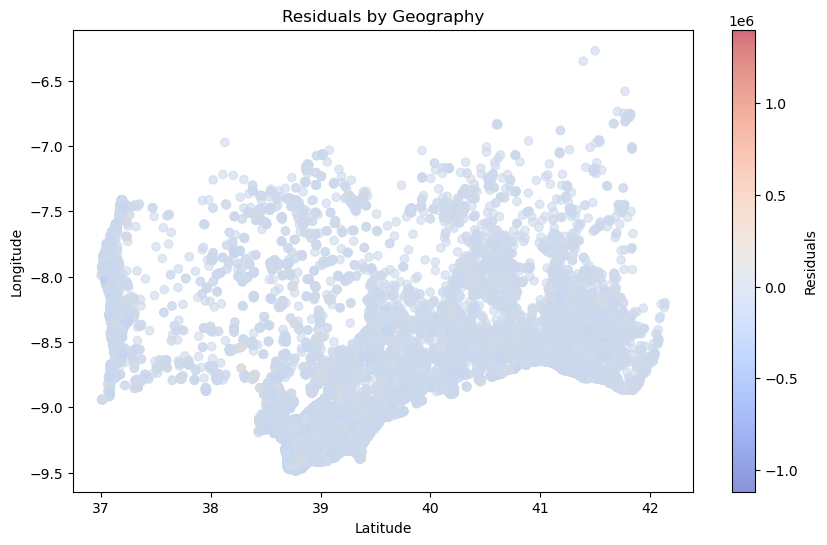

In [10]:
merged_data['residuals'] = residuals

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `residuals` are already calculated and available
merged_data['residuals'] = residuals

# Set a threshold value for analysis
threshold = 500000  # Example threshold value, adjust as needed

# Residuals vs. ABP (Área Bruta Privativa)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_data['ABP'], y=merged_data['residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ABP')
plt.ylabel('Residuals')
plt.title('Residuals vs ABP')
plt.show()

# Residuals by Property Type
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['TIPO_IMOVEL'], y=merged_data['residuals'])
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Property Type')
plt.ylabel('Residuals')
plt.title('Residuals by Property Type')
plt.show()

# Print recommendations based on the analysis
print("Recommendations based on the analysis:")
if merged_data['residuals'].std() > threshold:
    print("Consider creating separate models for different property types or locations.")

# Check standard deviation of residuals by FREGUESIA
std_by_freguesia = merged_data.groupby('FREGUESIA')['residuals'].std()
if std_by_freguesia.max() > threshold:
    print("Consider creating separate models for different locations. The following locations have high variability in residuals:")
    high_variability_freguesia = std_by_freguesia[std_by_freguesia > threshold]
    for freguesia, std_dev in high_variability_freguesia.items():
        print(f"- {freguesia}: {std_dev:.2f}")

# Residuals vs. Latitude and Longitude (Geography)
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['LATITUDE'], merged_data['LONGITUDE'], c=merged_data['residuals'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Residuals')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Residuals by Geography')
plt.show()

# Any additional analyses can be added here, such as by other features like 'm2' or time-related features.



Mean Residual: 9.009495181971584
Standard Deviation of Residuals: 48036.91321307514
90th Percentile: 43506.46875
95th Percentile: 67336.421875
99th Percentile: 146461.9187500002


C:\Users\ext.raimundo.mujica\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


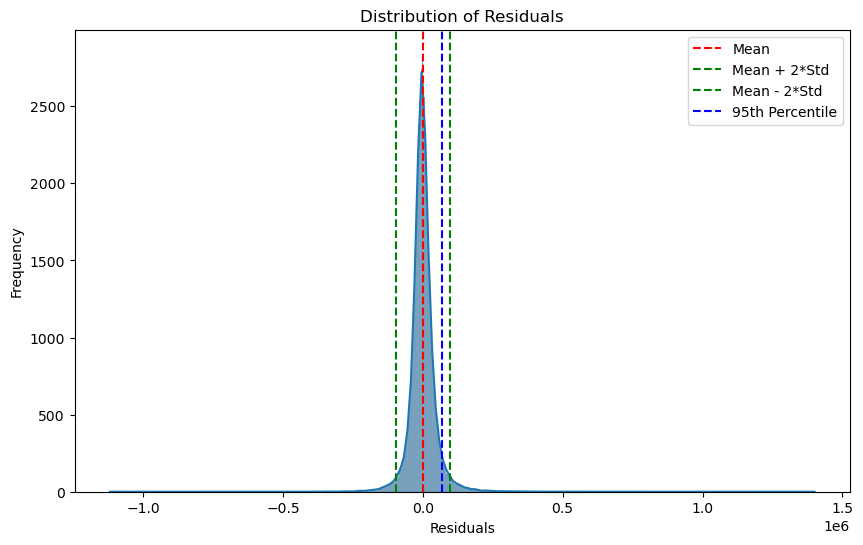

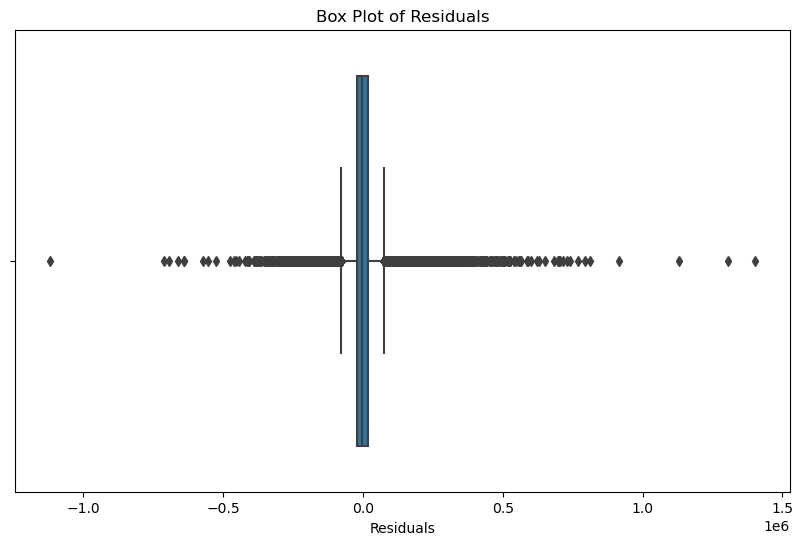

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate summary statistics
mean_residual = np.mean(merged_data['residuals'])
std_residual = np.std(merged_data['residuals'])
percentiles = np.percentile(merged_data['residuals'], [90, 95, 99])

print(f"Mean Residual: {mean_residual}")
print(f"Standard Deviation of Residuals: {std_residual}")
print(f"90th Percentile: {percentiles[0]}")
print(f"95th Percentile: {percentiles[1]}")
print(f"99th Percentile: {percentiles[2]}")

# Visualize the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['residuals'], kde=True)
plt.axvline(mean_residual, color='r', linestyle='--', label='Mean')
plt.axvline(mean_residual + 2*std_residual, color='g', linestyle='--', label='Mean + 2*Std')
plt.axvline(mean_residual - 2*std_residual, color='g', linestyle='--', label='Mean - 2*Std')
plt.axvline(percentiles[1], color='b', linestyle='--', label='95th Percentile')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Box plot for residuals
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['residuals'])
plt.xlabel('Residuals')
plt.title('Box Plot of Residuals')
plt.show()


Recommendations based on the analysis:
Consider creating separate models for different locations. The following locations have high variability in residuals:
- 021102: 74194.02
- 021117: 81959.69
- 030215: 87079.34
- 031112: 84594.67
- 060122: 138031.08
- 070502: 107342.50
- 080106: 72048.81
- 080503: 82340.10
- 080604: 110386.84
- 080704: 74118.06
- 080801: 180172.51
- 081102: 76619.84
- 081504: 68737.16
- 100925: 69570.61
- 110203: 69191.26
- 110508: 70132.11
- 110602: 70758.38
- 110610: 77241.27
- 110655: 79900.16
- 110656: 76538.87
- 110657: 106916.96
- 110658: 80329.65
- 110659: 87420.15
- 110660: 92661.14
- 110661: 107147.83
- 110662: 80971.41
- 110665: 86376.67
- 110666: 101733.89
- 111105: 68323.06
- 111202: 69819.26
- 130129: 93240.42
- 130722: 84797.77
- 131216: 75706.70
- 141104: 83481.46
- 141629: 86831.83
- 150106: 129523.63
- 150505: 75710.87
- 160128: 92465.08
- 160201: 92429.75
- 160222: 69603.61
- 160717: 92504.33
- 160915: 76050.44
- 171436: 102474.03
- 180404: 104911

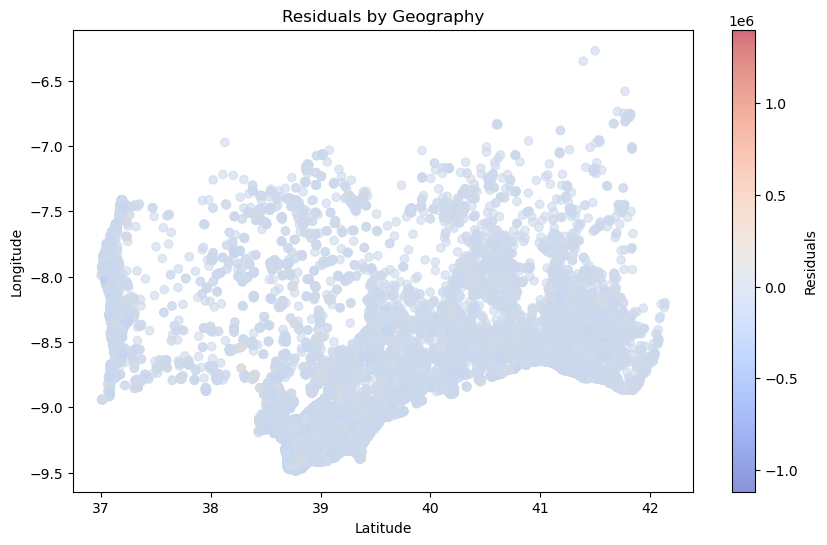

In [12]:
# Set a threshold value for analysis based on the data's characteristics
threshold = percentiles[1]  # Example: using the 95th percentile as the threshold

# Recommendations based on the analysis
print("Recommendations based on the analysis:")
if merged_data['residuals'].std() > threshold:
    print("Consider creating separate models for different property types or locations.")

# Check standard deviation of residuals by FREGUESIA
std_by_freguesia = merged_data.groupby('FREGUESIA')['residuals'].std()
if std_by_freguesia.max() > threshold:
    print("Consider creating separate models for different locations. The following locations have high variability in residuals:")
    high_variability_freguesia = std_by_freguesia[std_by_freguesia > threshold]
    for freguesia, std_dev in high_variability_freguesia.items():
        print(f"- {freguesia}: {std_dev:.2f}")

# Residuals vs. Latitude and Longitude (Geography)
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['LATITUDE'], merged_data['LONGITUDE'], c=merged_data['residuals'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Residuals')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Residuals by Geography')
plt.show()


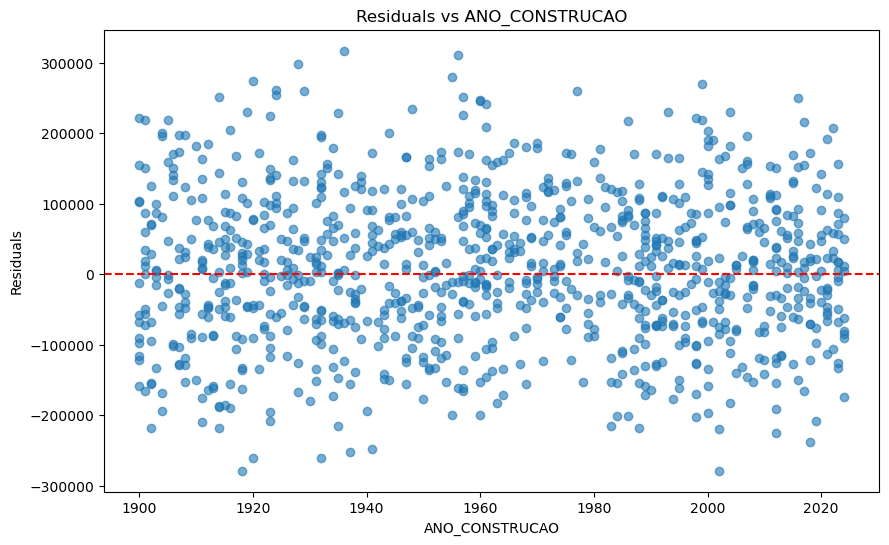

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'merged_data' and 'residuals' have been defined in the environment
# Here we are simulating them with random data for the sake of demonstration
# Replace this with your actual data
import numpy as np

# Simulated data (for demonstration purposes)
np.random.seed(42)
merged_data = pd.DataFrame({
    'ANO_CONSTRUCAO': np.random.choice(range(1900, 2025), 1000),
    'residuals': np.random.randn(1000) * 100000  # Random residuals for demonstration
})

# Plotting Residuals vs ANO_CONSTRUCAO
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['ANO_CONSTRUCAO'], merged_data['residuals'], alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('ANO_CONSTRUCAO')
plt.ylabel('Residuals')
plt.title('Residuals vs ANO_CONSTRUCAO')
plt.show()


## Geographical Error Analysis

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np

# Assuming 'data' is your initial DataFrame and 'target' is the target variable
X = data.drop(columns=['target'])
y = data['target']

# Ensure the indices of X and y are aligned with merged_data
X.index = merged_data.index
y.index = merged_data.index

# Define numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', Ridge())])

# Initialize the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize columns to store predictions and errors
merged_data['predicted_price'] = np.nan
merged_data['error'] = np.nan

# Perform the cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Ensure test_index matches merged_data indices
    valid_test_index = merged_data.index.intersection(test_index)
    merged_data.loc[valid_test_index, 'predicted_price'] = y_test_pred
    merged_data.loc[valid_test_index, 'error'] = y_test_pred - y_test.loc[valid_test_index]

# Check the updated merged_data DataFrame
print(merged_data.head())



NameError: name 'data' is not defined

## Time-Based Error Analysis

In [ ]:
# Assuming 'merged_data' contains a 'date' or 'year' column

# Add the prediction errors to the merged_data DataFrame
merged_data['year'] = pd.to_datetime(merged_data['DATA_OFERTA_INICIAL']).dt.year
merged_data['error'] = np.nan
merged_data.loc[test_index, 'error'] = np.abs(y_test - y_test_pred)

# Calculate average error by year
error_by_year = merged_data.groupby('year')['error'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=error_by_year, x='year', y='error', marker='o')
plt.title('Average Error by Year')
plt.xlabel('Year')
plt.ylabel('Average Error')
plt.show()


## Property Characteristics Error Analysis

In [ ]:
# Add the prediction errors to the merged_data DataFrame
merged_data['error'] = np.nan
merged_data.loc[test_index, 'error'] = np.abs(y_test - y_test_pred)

# Error by property size (e.g., square meters)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='ABP', y='error')
plt.title('Error by Property Size')
plt.xlabel('Square Meters')
plt.ylabel('Error')
plt.show()

# Error by number of rooms
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_data, x='N_QUARTOS', y='error')
plt.title('Error by Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Error')
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
import datetime

# Custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        current_year = datetime.datetime.now().year
        X = X.copy()
        X['IDADE_IMOVEL'] = current_year - X['ANO_CONSTRUCAO']

        bins_abp = [0, 50, 100, 150, 200, np.inf]
        labels_abp = ['0-50', '51-100', '101-150', '151-200', '200+']
        X['ABP_BINNED'] = pd.cut(X['ABP'], bins=bins_abp, labels=labels_abp)

        X['LAT_LONG_INTERACTION'] = X['LATITUDE'] * X['LONGITUDE']

        bins_idade = [0, 10, 20, 50, 100, np.inf]
        labels_idade = ['0-10', '11-20', '21-50', '51-100', '100+']
        X['IDADE_GRUPO'] = pd.cut(X['IDADE_IMOVEL'], bins=bins_idade, labels=labels_idade)

        return X

# Specify numeric and categorical features
numeric_features = ['N_QUARTOS', 'ABP', 'LATITUDE', 'LONGITUDE', 'ANO_CONSTRUCAO']
categorical_features = ['TIPO_IMOVEL', 'CCE', 'FREGUESIA', 'CP7', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ABP_BINNED', 'IDADE_GRUPO']

# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())  # Using TargetEncoder for encoding
])

# Combine preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Neural Network model function
def build_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=len(numeric_features) + len(categorical_features), kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

# Function to create the pipeline
def create_pipeline(model_type='linear_regression'):
    if model_type == 'xgboost':
        regressor = XGBRegressor(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=1.0,
                                 colsample_bytree=1.0, gamma=0, reg_lambda=5, random_state=42)
    elif model_type == 'linear_regression':
        regressor = LinearRegression(fit_intercept=True)
    elif model_type == 'decision_tree':
        regressor = DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, min_samples_leaf=10, 
                                          min_samples_split=2, splitter='best')
    elif model_type == 'random_forest':
        regressor = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, 
                                          max_depth=20, criterion='squared_error', bootstrap=True, random_state=42)
    elif model_type == 'neural_network':
        regressor = KerasRegressor(build_fn=build_nn_model, batch_size=10, epochs=100, verbose=0)
    else:
        raise ValueError("Invalid model_type. Choose 'xgboost', 'linear_regression', 'decision_tree', 'random_forest', or 'neural_network'.")
    
    pipeline = Pipeline(steps=[
        ('feature_engineering', FeatureEngineering()),
        ('feature_selection', ColumnTransformer(
            transformers=[
                ('selected', 'passthrough', ['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])
            ], remainder='drop')),
        ('ensure_dataframe', EnsureDataFrame(columns=['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO'])),
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    return pipeline

# Load your data
cubo_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\Cubo_202203_NOVAIMS_2022-05-13.xlsx")
year_construction_data = pd.read_excel("C:\\Users\\ext.raimundo.mujica\\Desktop\\THESIS\\20220725_ano_construcao.xlsx")
merged_data = cubo_data.merge(year_construction_data, on='IMOVEL_ID', how='left')

# Remove rows with missing target
merged_data = merged_data.dropna(subset=['PRECO_VENDA_OBSERVADO'])

# Define feature matrix X and target vector y
X = merged_data.drop('PRECO_VENDA_OBSERVADO', axis=1)
y = merged_data['PRECO_VENDA_OBSERVADO']

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Function to evaluate the model
def evaluate_model(model_type):
    # Initialize lists to hold the scores
    train_mae_list = []
    train_rmse_list = []
    train_r2_list = []
    test_mae_list = []
    test_rmse_list = []
    test_r2_list = []

    pipeline = create_pipeline(model_type=model_type)

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Ensure X_train and X_test are DataFrames
        X_train = pd.DataFrame(X_train, columns=X.columns)
        X_test = pd.DataFrame(X_test, columns=X.columns)

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)

        # Predict on the training and testing data
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Calculate training metrics
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)

        # Calculate testing metrics
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # Append the scores
        train_mae_list.append(train_mae)
        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)
        test_mae_list.append(test_mae)
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    # Calculate average metrics
    avg_train_mae = np.mean(train_mae_list)
    avg_train_rmse = np.mean(train_rmse_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_test_mae = np.mean(test_mae_list)
    avg_test_rmse = np.mean(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)

    print(f"Model: {model_type}")
    print("Average Train MAE:", avg_train_mae)
    print("Average Train RMSE:", avg_train_rmse)
    print("Average Train R2:", avg_train_r2)
    print("Average Test MAE:", avg_test_mae)
    print("Average Test RMSE:", avg_test_rmse)
    print("Average Test R2:", avg_test_r2)
    print("\n")



In [12]:
evaluate_model('xgboost')

Model: xgboost
Average Train MAE: 29007.883822709824
Average Train RMSE: 46941.54386316503
Average Train R2: 0.9476822785556573
Average Test MAE: 47943.06722018165
Average Test RMSE: 100331.8090695918
Average Test R2: 0.7607523791498773




In [13]:
evaluate_model('linear_regression')


Model: linear_regression
Average Train MAE: 64422.72619368548
Average Train RMSE: 122380.53875096787
Average Train R2: 0.6444241608473468
Average Test MAE: 67272.51283671075
Average Test RMSE: 129521.5501558315
Average Test R2: 0.6014247599872138




In [14]:
evaluate_model('decision_tree')


Model: decision_tree
Average Train MAE: 40699.60932468022
Average Train RMSE: 76654.75592179809
Average Train R2: 0.8604917090105086
Average Test MAE: 60122.404223606645
Average Test RMSE: 119938.54040897408
Average Test R2: 0.6580323137094697




In [15]:
evaluate_model('random_forest')


Model: random_forest
Average Train MAE: 18701.91836337259
Average Train RMSE: 33526.17835103848
Average Train R2: 0.973314494511125
Average Test MAE: 50744.72675470606
Average Test RMSE: 107242.31855133784
Average Test R2: 0.7266845039362981




In [16]:
evaluate_model('neural_network')

C:\Users\ext.raimundo.mujica\AppData\Local\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ext.raimundo.mujica\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ext.raimundo.mujica\AppData\Local\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\ext.raimundo.mujica\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.p

Model: neural_network
Average Train MAE: 49583.80348897461
Average Train RMSE: 98953.253828323
Average Train R2: 0.7674596881925179
Average Test MAE: 63204.811288244266
Average Test RMSE: 124935.80291602193
Average Test R2: 0.6290359804356627




# Split the Data

In [5]:
if 'PRECO_VENDA_OBSERVADO' in merged_data.columns:
     merged_data = merged_data.dropna(subset=['PRECO_VENDA_OBSERVADO'])

In [6]:
print("Columns in merged_data:", merged_data.columns)

Columns in merged_data: Index(['IMOVEL_ID', 'TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA',
       'CP7', 'LATITUDE', 'LONGITUDE', 'GARAGEM', 'TERRACO', 'PISCINA',
       'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO',
       'ULTIMA_DATA_EM_MERCADO', 'DATA_OFERTA_INCIAL', 'VALOR_OFERTA_INICIAL',
       'VALOR_OFERTA_ATUAL_FINAL', 'PRECO_VENDA_ESTIMADO',
       'PRECO_VENDA_OBSERVADO', 'INDICE_MAIS_RECENTE',
       'INDICE_ULTIMA_DATA_EM_MERCADO', 'ANO_CONSTRUCAO'],
      dtype='object')


In [7]:
merged_data = merged_data[['IMOVEL_ID', 'TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA',
       'CP7', 'LATITUDE', 'LONGITUDE', 'GARAGEM', 'TERRACO', 'PISCINA',
       'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO',
       'PRECO_VENDA_OBSERVADO', 'ANO_CONSTRUCAO']]

In [8]:
data = merged_data.copy()

In [9]:
X = merged_data[['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA',
       'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO',
       'ANO_CONSTRUCAO']]
y = merged_data['PRECO_VENDA_OBSERVADO']

In [ ]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        current_year = datetime.datetime.now().year
        X = X.copy()
        X['IDADE_IMOVEL'] = current_year - X['ANO_CONSTRUCAO']

        bins_abp = [0, 50, 100, 150, 200, np.inf]
        labels_abp = ['0-50', '51-100', '101-150', '151-200', '200+']
        X['ABP_BINNED'] = pd.cut(X['ABP'], bins=bins_abp, labels=labels_abp)

        X['LAT_LONG_INTERACTION'] = X['LATITUDE'] * X['LONGITUDE']

        bins_idade = [0, 10, 20, 50, 100, np.inf]
        labels_idade = ['0-10', '11-20', '21-50', '51-100', '100+']
        X['IDADE_GRUPO'] = pd.cut(X['IDADE_IMOVEL'], bins=bins_idade, labels=labels_idade)

        return X

In [1]:
numeric_features = ['N_QUARTOS', 'ABP', 'LATITUDE', 'LONGITUDE', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'LAT_LONG_INTERACTION']
categorical_features = ['TIPO_IMOVEL', 'CCE', 'FREGUESIA',
       'CP7', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ABP_BINNED', 'IDADE_GRUPO']

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())  # Using TargetEncoder for encoding
])

# Data Understanding

In [11]:
merged_data.shape

(119191, 17)

In [12]:
merged_data.tail(5)

,IMOVEL_ID,TIPO_IMOVEL,N_QUARTOS,CCE,ABP,FREGUESIA,CP7,LATITUDE,LONGITUDE,GARAGEM,TERRACO,PISCINA,LOGRADOURO,ESTADO_DE_CONSERVACAO,FLAG_ESTADO_DE_CONSERVACAO,PRECO_VENDA_OBSERVADO,ANO_CONSTRUCAO
326532,99993,1,2,6,93,030351,4710-409,41.556072,-8.401548,1.0,NaN,NaN,NaN,usado,V0,132500.0,NaN
326533,99994,1,2,3,118,030371,4705-293,41.534738,-8.453001,1.0,NaN,NaN,NaN,usado,V0,89000.0,NaN
326534,99995,2,3,3,182,030313,4705-475,41.511224,-8.427049,1.0,NaN,NaN,NaN,usado,V0,170000.0,NaN
326536,99997,1,2,5,74,131203,4300-200,41.156555,-8.577782,NaN,NaN,NaN,NaN,usado,V0,75000.0,NaN
326538,99999,1,1,5,73,081303,8365-149,37.101145,-8.358735,1.0,NaN,NaN,NaN,usado,V0,147000.0,NaN


In [13]:
merged_data.describe()

,TIPO_IMOVEL,N_QUARTOS,CCE,ABP,LATITUDE,LONGITUDE,GARAGEM,TERRACO,PISCINA,LOGRADOURO,PRECO_VENDA_OBSERVADO,ANO_CONSTRUCAO
count,119191.000000,119191.000000,119191.000000,119191.000000,119191.000000,119191.000000,65849.000000,59929.000000,59929.000000,59929.000000,1.191910e+05,18507.000000
mean,1.185777,2.404385,3.922989,110.849091,39.334728,-8.880823,0.209160,0.056734,0.031103,0.108111,2.093626e+05,1782.967472
std,0.388929,1.116226,2.752119,60.931832,1.198410,0.417881,0.406712,0.231335,0.173599,0.310523,2.052347e+05,572.201178
min,1.000000,0.000000,0.000000,26.000000,37.004794,-9.485756,0.000000,0.000000,0.000000,0.000000,2.550000e+04,0.000000
25%,1.000000,2.000000,0.000000,73.000000,38.709515,-9.173436,0.000000,0.000000,0.000000,0.000000,1.060000e+05,1932.000000
50%,1.000000,2.000000,5.000000,96.000000,38.766166,-9.092559,0.000000,0.000000,0.000000,0.000000,1.525000e+05,1953.000000
75%,1.000000,3.000000,6.000000,128.000000,40.291704,-8.597387,0.000000,0.000000,0.000000,0.000000,2.405000e+05,1986.000000
max,2.000000,13.000000,9.000000,947.000000,42.132721,-6.270873,1.000000,1.000000,1.000000,1.000000,4.950000e+06,2022.000000


In [14]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119191 entries, 0 to 326538
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   IMOVEL_ID                   119191 non-null  object 
 1   TIPO_IMOVEL                 119191 non-null  int64  
 2   N_QUARTOS                   119191 non-null  int64  
 3   CCE                         119191 non-null  int64  
 4   ABP                         119191 non-null  int64  
 5   FREGUESIA                   119191 non-null  object 
 6   CP7                         119191 non-null  object 
 7   LATITUDE                    119191 non-null  float64
 8   LONGITUDE                   119191 non-null  float64
 9   GARAGEM                     65849 non-null   float64
 10  TERRACO                     59929 non-null   float64
 11  PISCINA                     59929 non-null   float64
 12  LOGRADOURO                  59929 non-null   float64
 13  ESTADO_DE_CONSERVAC

# Data Preprocesing

In [15]:
merged_data['FREGUESIA'].value_counts()

FREGUESIA
110656    2945
131217    2110
110663    2048
110657    1940
110654    1578
          ... 
060113       1
050427       1
130705       1
170609       1
141614       1
Name: count, Length: 1976, dtype: int64

In [16]:
 merged_data['TIPO_IMOVEL'].value_counts()

TIPO_IMOVEL
1    97048
2    22143
Name: count, dtype: int64

In [17]:
merged_data['CP7'].value_counts()

CP7
1750-220    211
7570-789    184
2950-559    172
2580-346    163
8200-184    145
           ... 
2695-622      1
2690-450      1
8100-033      1
1400-267      1
4705-475      1
Name: count, Length: 36730, dtype: int64

In [18]:
merged_data['ESTADO_DE_CONSERVACAO'].value_counts()

ESTADO_DE_CONSERVACAO
usado    102651
novo      10705
bom        5591
mau         244
Name: count, dtype: int64

In [19]:
merged_data['FLAG_ESTADO_DE_CONSERVACAO'].value_counts()

FLAG_ESTADO_DE_CONSERVACAO
V0    89235
V1    29956
Name: count, dtype: int64

In [20]:
merged_data['N_QUARTOS'].value_counts()

N_QUARTOS
2     44147
3     37994
1     16689
4     11335
0      4851
5      3143
6       800
7       142
8        67
9         9
10        9
11        2
13        2
12        1
Name: count, dtype: int64

In [21]:
merged_data['ANO_CONSTRUCAO'].min(), merged_data['ANO_CONSTRUCAO'].max()

(0.0, 2022.0)

## Missing Values

In [22]:
X_train['ANO_CONSTRUCAO'].value_counts

<bound method IndexOpsMixin.value_counts of 237685       NaN
202779    1976.0
244622       NaN
182778       NaN
158294       NaN
           ...  
15928        NaN
276835       NaN
56194        NaN
50973        NaN
121658       NaN
Name: ANO_CONSTRUCAO, Length: 89393, dtype: float64>

In [23]:
X_train['ANO_CONSTRUCAO'].notna().sum()

13859

In [24]:
X_train['ANO_CONSTRUCAO'].isna().sum()

75534

In [25]:
median_ano_construcao = X_train['ANO_CONSTRUCAO'].median()

In [26]:
print(f'Number of missing values in column ANO_CONSTRUCAO in X_train: {sum(X_train["ANO_CONSTRUCAO"].isna())}\n' +
     f'Number of missing values in column ANO_CONSTRUCAO in X_test: {sum(X_test["ANO_CONSTRUCAO"].isna())}')

Number of missing values in column ANO_CONSTRUCAO in X_train: 75534
Number of missing values in column ANO_CONSTRUCAO in X_test: 25150


In [27]:
#filling nans in X_train
X_train['ANO_CONSTRUCAO'].fillna(median_ano_construcao, inplace = True)

#filling nans in X_test
X_test['ANO_CONSTRUCAO'].fillna(median_ano_construcao, inplace = True)

In [28]:
print(f'Number of missing values in column ANO_CONSTRUCAO in X_train: {sum(X_train["ANO_CONSTRUCAO"].isna())}\n' +
     f'Number of missing values in column ANO_CONSTRUCAO in X_test: {sum(X_test["ANO_CONSTRUCAO"].isna())}')

Number of missing values in column ANO_CONSTRUCAO in X_train: 0
Number of missing values in column ANO_CONSTRUCAO in X_test: 0


In [29]:
X_train['ANO_CONSTRUCAO'].value_counts().unique()

array([77898,  1936,  1270,  1095,   935,   774,   757,   288,   280,
         251,   235,   213,   182,   172,   168,   156,   137,   135,
         123,   122,   118,    88,    85,    78,    64,    61,    57,
          54,    50,    49,    45,    43,    42,    41,    38,    36,
          35,    32,    31,    30,    29,    28,    27,    26,    25,
          24,    22,    21,    19,    18,    17,    16,    15,    14,
          13,    12,    11,    10,     9,     8,     7,     5,     4,
           3,     2,     1], dtype=int64)

In [30]:
print(f'Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_train: {X_train[["GARAGEM", "TERRACO", "PISCINA", "LOGRADOURO"]].isna().sum().sum()}\n' +
     f'Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_test: {X_test[["GARAGEM", "TERRACO", "PISCINA", "LOGRADOURO"]].isna().sum().sum()}')

Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_train: 173123
Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_test: 58005


In [31]:
X_train[['GARAGEM', 'TERRACO', 'PISCINA', 'LOGRADOURO']] = X_train[['GARAGEM', 'TERRACO', 'PISCINA', 'LOGRADOURO']].fillna(0)
X_test[['GARAGEM', 'TERRACO', 'PISCINA', 'LOGRADOURO']] = X_test[['GARAGEM', 'TERRACO', 'PISCINA', 'LOGRADOURO']].fillna(0)


In [32]:
print(f'Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_train: {X_train[["GARAGEM", "TERRACO", "PISCINA", "LOGRADOURO"]].isna().sum().sum()}\n' +
     f'Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_test: {X_test[["GARAGEM", "TERRACO", "PISCINA", "LOGRADOURO"]].isna().sum().sum()}')

Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_train: 0
Number of missing values in columns GARAGEM, TERRACO, PISCINA, LOGRADOURO in X_test: 0


## Feature Engenieering

In [33]:
current_year = datetime.datetime.now().year
X_train['IDADE_IMOVEL'] = current_year - X_train['ANO_CONSTRUCAO']
X_test['IDADE_IMOVEL'] = current_year - X_test['ANO_CONSTRUCAO']

In [34]:
bins = [0, 50, 100, 150, 200, np.inf]
labels = ['0-50', '51-100', '101-150', '151-200', '200+']
X_train['ABP_BINNED'] = pd.cut(X_train['ABP'], bins=bins, labels=labels)
X_test['ABP_BINNED'] = pd.cut(X_test['ABP'], bins=bins, labels=labels)

In [35]:
X_train['LAT_LONG_INTERACTION'] = X_train['LATITUDE'] * X_train['LONGITUDE']
X_test['LAT_LONG_INTERACTION'] = X_test['LATITUDE'] * X_test['LONGITUDE']

X_train['GARAGE_TERRACE_INTERACTION'] = X_train['GARAGEM'] * X_train['TERRACO']
X_test['GARAGE_TERRACE_INTERACTION'] = X_test['GARAGEM'] * X_test['TERRACO']

bins = [0, 10, 20, 50, 100, np.inf]
labels = ['0-10', '11-20', '21-50', '51-100', '100+']
X_train['IDADE_GRUPO'] = pd.cut(X_train['IDADE_IMOVEL'], bins=bins, labels=labels)
X_test['IDADE_GRUPO'] = pd.cut(X_test['IDADE_IMOVEL'], bins=bins, labels=labels)

## Encoding Data

In [36]:
columns_to_encode = ['TIPO_IMOVEL', 'CCE', 'FREGUESIA', 'CP7', 'GARAGEM', 'TERRACO', 'PISCINA',
                     'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO',
                     'ABP_BINNED', 'IDADE_GRUPO']

In [37]:
encoder = ce.TargetEncoder(cols=columns_to_encode)

In [38]:
encoder.fit(X_train[columns_to_encode], y_train)

TargetEncoder(cols=['TIPO_IMOVEL', 'CCE', 'FREGUESIA', 'CP7', 'GARAGEM',
                    'TERRACO', 'PISCINA', 'LOGRADOURO', 'ESTADO_DE_CONSERVACAO',
                    'FLAG_ESTADO_DE_CONSERVACAO', 'ABP_BINNED', 'IDADE_GRUPO'])

In [39]:
X_train[columns_to_encode] = encoder.transform(X_train[columns_to_encode])
X_test[columns_to_encode] = encoder.transform(X_test[columns_to_encode])

## Scaling the Data

In [40]:
feature_scaler = StandardScaler().fit(X_train)

In [41]:
X_train_scaled = pd.DataFrame(feature_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(feature_scaler.transform(X_test), columns= X_test.columns, index=X_test.index)

## Feature Selection

In [42]:
numeric_columns = X_train_scaled.select_dtypes(include=[np.number]).columns.tolist()

In [43]:
#wrapper methods
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [44]:
# Number of features to keep
nof_list=np.arange(2,16)            
high_score = float('inf')
# Variable to store the optimum features
nof=0           

#list of scores
score_list =[]

for n in range(len(nof_list)):
    model = LinearRegression()
    
    # Create instance of RFE
    rfe = RFE(model, n_features_to_select=nof_list[n])
    
    # Fit RFE to training data
    X_train_rfe = rfe.fit_transform(X_train_scaled[numeric_columns], y_train)
    
    # Apply the same RFE transformation to the test data
    X_test_rfe = rfe.transform(X_test_scaled[numeric_columns])
    
    # Create and train instance of Linear Regression
    model.fit(X_train_rfe, y_train)
    
    # Predict
    y_pred = model.predict(X_test_rfe)
    
    # Store mean squared error in variable
    mse = mean_squared_error(y_test, y_pred)
    
    score_list.append(mse)
    
    # Compare against previous best performance
    if mse < high_score:
        high_score = mse
        nof = nof_list[n]

print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 15
Score with 15 features: 16512175880.382381


In [45]:
X_train_scaled.shape

(89393, 21)

In [46]:
X_test_scaled.shape

(29798, 21)

In [47]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89393 entries, 237685 to 121658
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IMOVEL_ID                   89393 non-null  float64
 1   TIPO_IMOVEL                 89393 non-null  float64
 2   N_QUARTOS                   89393 non-null  float64
 3   CCE                         89393 non-null  float64
 4   ABP                         89393 non-null  float64
 5   FREGUESIA                   89393 non-null  float64
 6   CP7                         89393 non-null  float64
 7   LATITUDE                    89393 non-null  float64
 8   LONGITUDE                   89393 non-null  float64
 9   GARAGEM                     89393 non-null  float64
 10  TERRACO                     89393 non-null  float64
 11  PISCINA                     89393 non-null  float64
 12  LOGRADOURO                  89393 non-null  float64
 13  ESTADO_DE_CONSERVACAO       89

In [48]:
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29798 entries, 117087 to 132290
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IMOVEL_ID                   29798 non-null  float64
 1   TIPO_IMOVEL                 29798 non-null  float64
 2   N_QUARTOS                   29798 non-null  float64
 3   CCE                         29798 non-null  float64
 4   ABP                         29798 non-null  float64
 5   FREGUESIA                   29798 non-null  float64
 6   CP7                         29798 non-null  float64
 7   LATITUDE                    29798 non-null  float64
 8   LONGITUDE                   29798 non-null  float64
 9   GARAGEM                     29798 non-null  float64
 10  TERRACO                     29798 non-null  float64
 11  PISCINA                     29798 non-null  float64
 12  LOGRADOURO                  29798 non-null  float64
 13  ESTADO_DE_CONSERVACAO       29

In [49]:
# Pearson
numeric_cols = X_train_scaled.select_dtypes(include=[np.number])
cor_pearson = numeric_cols.corr()

<Axes: >

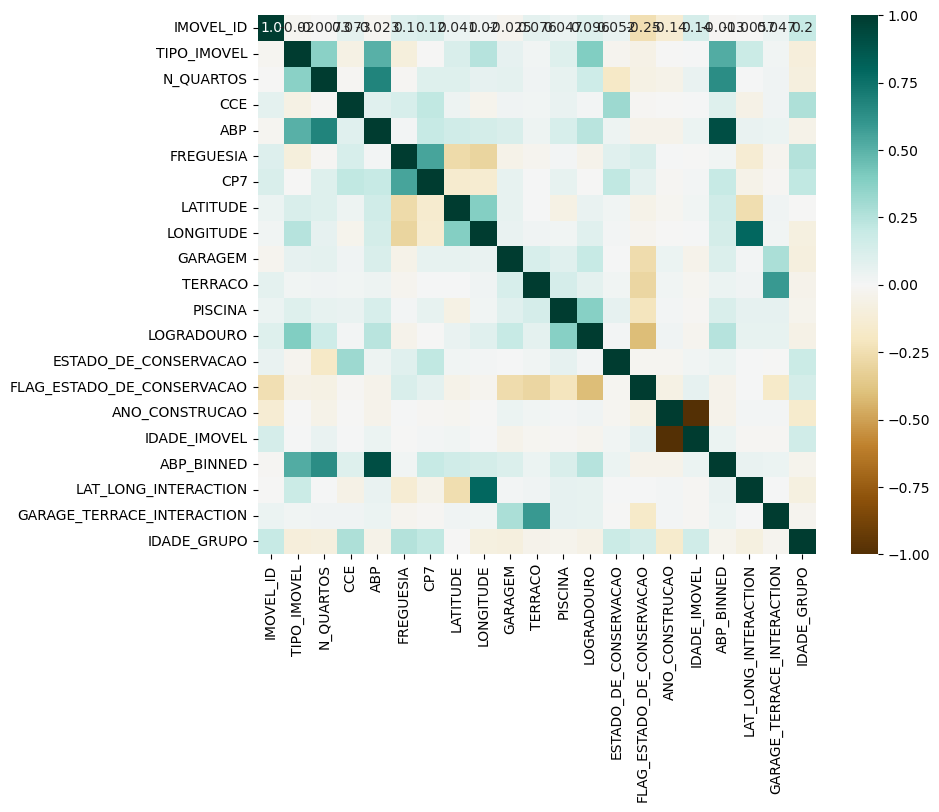

In [50]:
plt.figure(figsize=(9,7))
sns.heatmap(data=cor_pearson, annot=True, cmap = plt.cm.BrBG, fmt='.2')

In [51]:
# Spearman
cor_spearman = numeric_cols.corr(method ='spearman')

<Axes: >

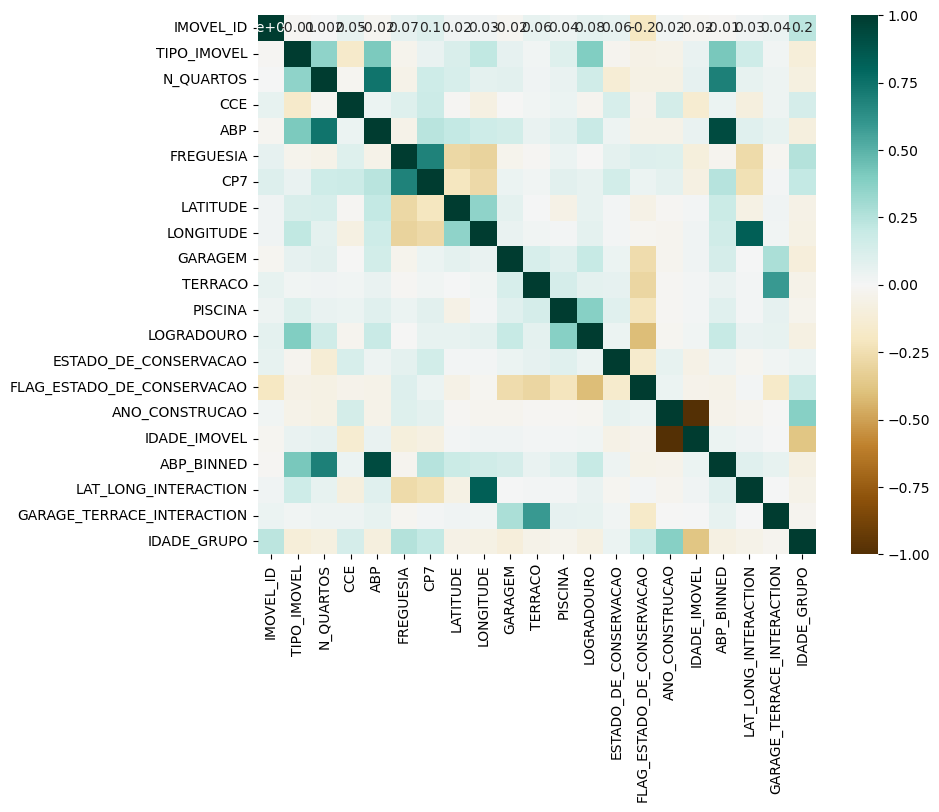

In [52]:
plt.figure(figsize=(9,7))
sns.heatmap(data=cor_spearman, annot=True, cmap = plt.cm.BrBG, fmt='.1')

In [53]:
print("Columns in X_train:", X_train_scaled.columns)

Columns in X_train: Index(['IMOVEL_ID', 'TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA',
       'CP7', 'LATITUDE', 'LONGITUDE', 'GARAGEM', 'TERRACO', 'PISCINA',
       'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO',
       'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION',
       'GARAGE_TERRACE_INTERACTION', 'IDADE_GRUPO'],
      dtype='object')


In [54]:
# ANOVA
anova = SelectKBest(f_classif, k=15)

In [55]:
X_df_numeric = X_train_scaled[numeric_columns] 
print("Numeric columns in X_train_scaled:", numeric_columns)

Numeric columns in X_train_scaled: ['IMOVEL_ID', 'TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'GARAGEM', 'TERRACO', 'PISCINA', 'LOGRADOURO', 'ESTADO_DE_CONSERVACAO', 'FLAG_ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'GARAGE_TERRACE_INTERACTION', 'IDADE_GRUPO']


In [56]:
X_anova = anova.fit_transform(X_df_numeric, y_train)

In [57]:
selected_features = pd.Series(anova.get_support(), index = X_df_numeric.columns)
selected_features

IMOVEL_ID                      True
TIPO_IMOVEL                    True
N_QUARTOS                      True
CCE                            True
ABP                            True
FREGUESIA                      True
CP7                            True
LATITUDE                       True
LONGITUDE                      True
GARAGEM                       False
TERRACO                       False
PISCINA                        True
LOGRADOURO                    False
ESTADO_DE_CONSERVACAO          True
FLAG_ESTADO_DE_CONSERVACAO    False
ANO_CONSTRUCAO                 True
IDADE_IMOVEL                   True
ABP_BINNED                     True
LAT_LONG_INTERACTION          False
GARAGE_TERRACE_INTERACTION    False
IDADE_GRUPO                    True
dtype: bool

In [58]:
X_train_scaled = X_train_scaled[['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO']]
X_test_scaled = X_test_scaled[['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO']]

## Spot Outliers

In [59]:
cols_num = ['N_QUARTOS', 'ABP','LATITUDE', 'LONGITUDE','ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'LAT_LONG_INTERACTION']

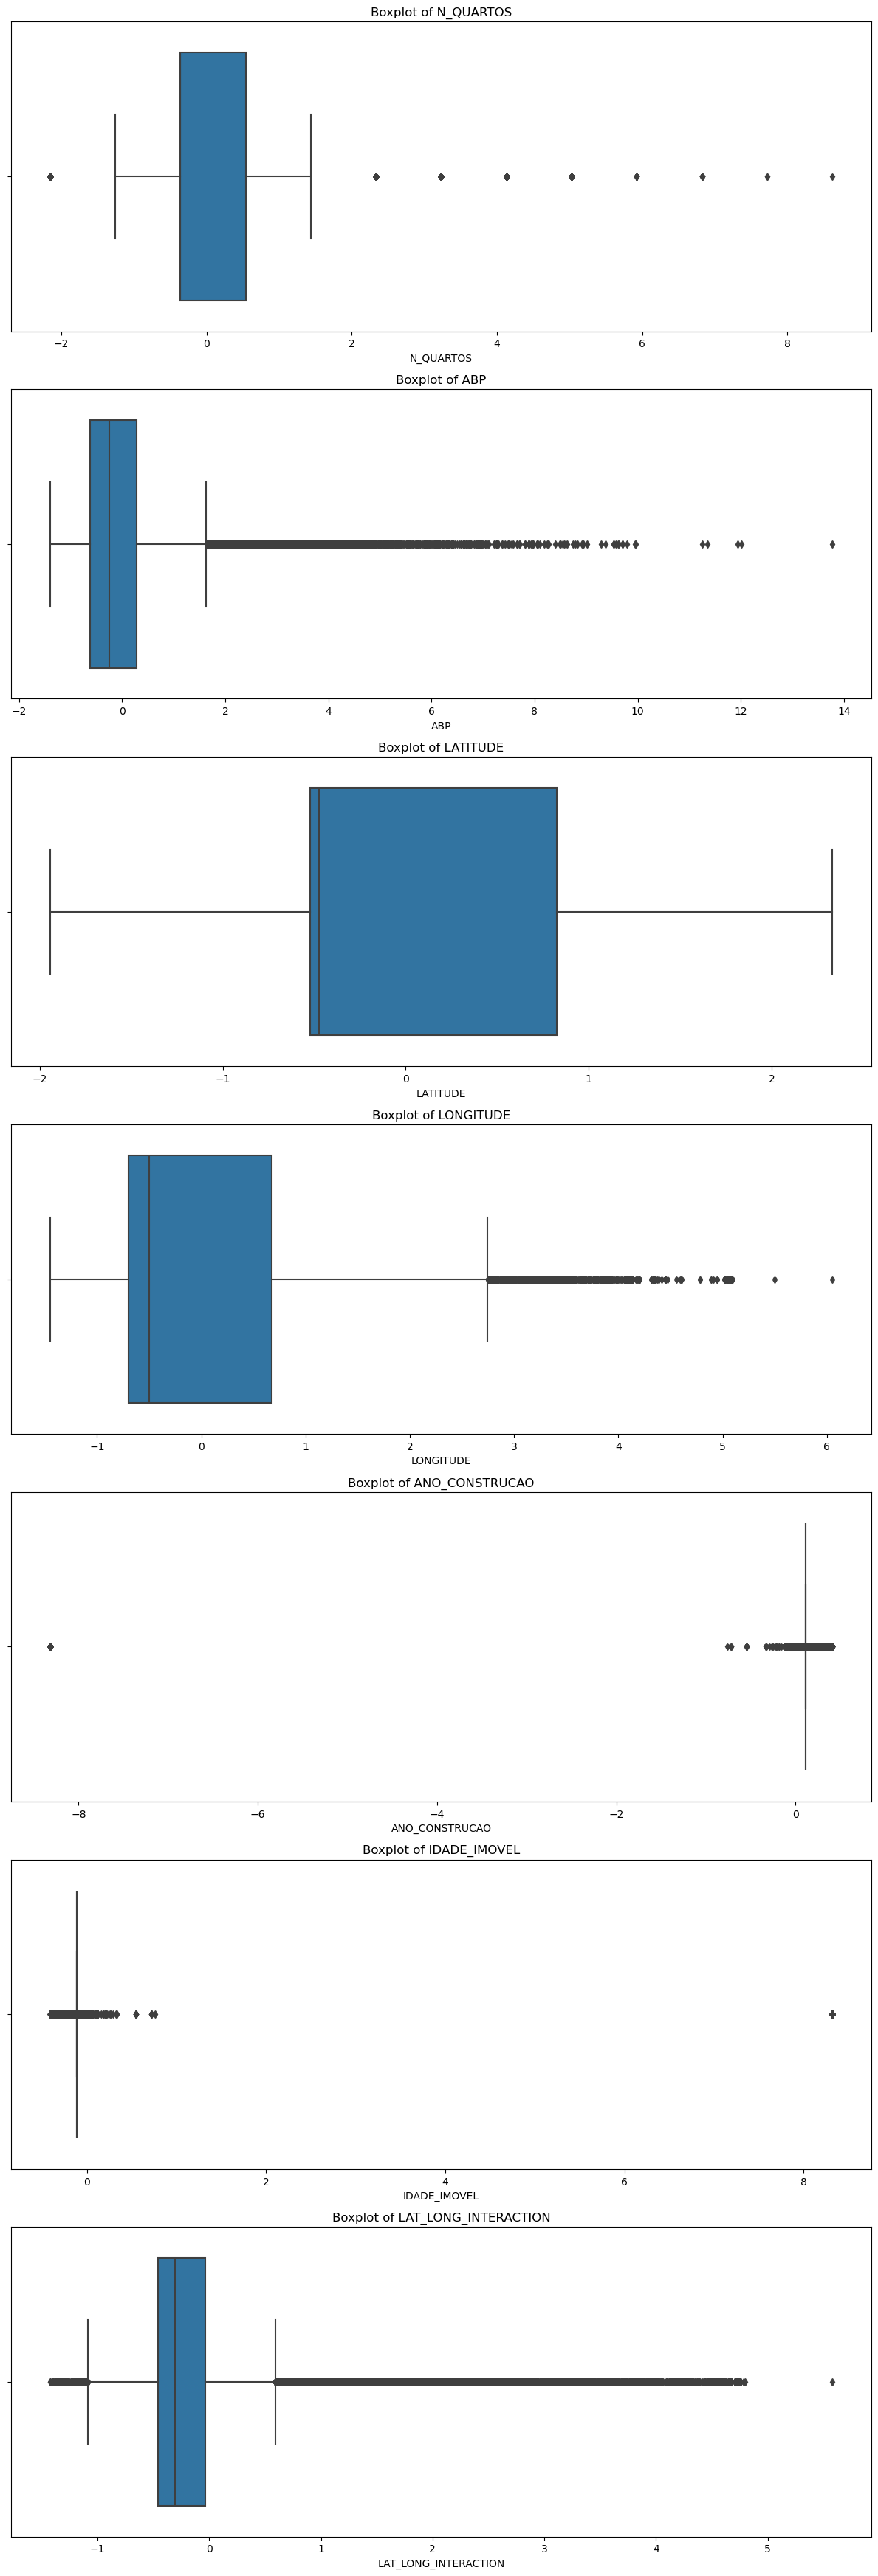

In [60]:
def plot_outliers(df, features):
    fig, axes = plt.subplots(len(features), 1, figsize=(12, 5*len(features)))
    
    for i, feature in enumerate(features):
        sns.boxplot(data=df, x=feature, ax=axes[i])
        axes[i].set_title(f'Boxplot of {feature}')
    
    plt.tight_layout()
    plt.show()

plot_outliers(X_train_scaled, cols_num)

In [63]:
X_train[['TIPO_IMOVEL', 'N_QUARTOS', 'CCE', 'ABP', 'FREGUESIA', 'CP7', 'LATITUDE', 'LONGITUDE', 'PISCINA', 'ESTADO_DE_CONSERVACAO', 'ANO_CONSTRUCAO', 'IDADE_IMOVEL', 'ABP_BINNED', 'LAT_LONG_INTERACTION', 'IDADE_GRUPO']].describe()

,TIPO_IMOVEL,N_QUARTOS,CCE,ABP,FREGUESIA,CP7,LATITUDE,LONGITUDE,PISCINA,ESTADO_DE_CONSERVACAO,ANO_CONSTRUCAO,IDADE_IMOVEL,ABP_BINNED,LAT_LONG_INTERACTION,IDADE_GRUPO
count,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000,8.939300e+04,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000,89393.000000
mean,209191.593727,2.401273,209191.604466,110.749779,214939.210129,2.134938e+05,39.336698,-8.879595,209191.593727,209191.593747,1927.123790,96.876210,209191.593727,-349.100084,209191.593727
std,10617.983202,1.114039,51863.471275,60.712681,110641.045998,6.221458e+04,1.199945,0.417882,22072.492915,36759.347818,231.679498,231.679498,82346.110841,15.460164,45060.499638
min,204129.370540,0.000000,160810.307671,26.000000,70997.692378,8.677911e+04,37.004794,-9.485756,206412.522614,99790.103486,0.000000,2.000000,131704.593128,-371.143000,197649.777089
25%,204129.370540,2.000000,185330.252312,73.000000,139475.912338,1.914437e+05,38.709557,-9.172406,206412.522614,196390.048133,1953.000000,71.000000,158070.467761,-356.199462,197649.777089
50%,204129.370540,2.000000,194614.581402,96.000000,175497.664915,1.995761e+05,38.766478,-9.089831,206412.522614,196390.048133,1953.000000,71.000000,158070.467761,-353.884282,197649.777089
75%,204129.370540,3.000000,215225.134897,128.000000,251257.628816,2.160773e+05,40.328292,-8.595992,206412.522614,196390.048133,1953.000000,71.000000,220122.259368,-349.701130,197649.777089
max,231462.501570,12.000000,453366.877971,947.000000,932642.478731,1.114580e+06,42.132721,-6.350685,384498.188530,322750.024143,2022.000000,2024.000000,447483.282556,-262.852473,505651.277574


# Modeling

## XGBoost

In [59]:
# Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'reg_lambda': 5, 'subsample': 1.0}
model_params = {
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_lambda': 5,
    'random_state': 42
}

In [60]:
def run_model_XGBoost(X, y):
    model = XGBRegressor(**model_params)
    model = model.fit(X, y)
    return model

In [61]:
def evaluate_model(X, y, model):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return mae, rmse, r2

In [62]:
kf = KFold(n_splits=10)

In [63]:
def avg_score_XGBoost(method, X, y):

    mae_train_list = []
    rmse_train_list = []
    r2_train_list = []
    
    mae_test_list = []
    rmse_test_list = []
    r2_test_list = []

    for train_index, test_index in method.split(X):

        X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run model function
        model = run_model_XGBoost(X_train_scaled, y_train)

        # Evaluate model function for training data
        mae_train, rmse_train, r2_train = evaluate_model(X_train_scaled, y_train, model)
        
        # Evaluate model function for test data
        mae_test, rmse_test, r2_test = evaluate_model(X_test_scaled, y_test, model)

        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        r2_train_list.append(r2_train)
        
        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        r2_test_list.append(r2_test)

    print('Train MAE:', np.mean(mae_train_list))
    print('Train RMSE:', np.mean(rmse_train_list))
    print('Train R2:', np.mean(r2_train_list))
    
    print('Test MAE:', np.mean(mae_test_list))
    print('Test RMSE:', np.mean(rmse_test_list))
    print('Test R2:', np.mean(r2_test_list))

In [64]:
avg_score_XGBoost(kf, X_train_scaled, y_train)

Train MAE: 27430.622399415333
Train RMSE: 43663.82794662365
Train R2: 0.9549647306682394
Test MAE: 35039.888677696756
Test RMSE: 70508.00472507274
Test R2: 0.8821586408362776


In [65]:
#param_grid = {
#    'n_estimators': [100, 300, 500],
#    'max_depth': [3, 5, 7],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0],
#    'gamma': [0, 1, 5],
#    'reg_lambda': [1, 2, 5]
#}

In [66]:
#xgb_model = XGBRegressor(random_state=42)

In [67]:
#grid_search = GridSearchCV(estimator=xgb_model,
#                           param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [68]:
#grid_search.fit(X_train_scaled, y_train)

In [69]:
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

In [70]:
#best_model = grid_search.best_estimator_

In [71]:
#train_mae, train_rmse, train_r2 = evaluate_model(X_train_scaled, y_train, best_model)
#test_mae, test_rmse, test_r2 = evaluate_model(X_test_scaled, y_test, best_model)

In [72]:
#print(f"Best Model Train MAE: {train_mae}")
#print(f"Best Model Train RMSE: {train_rmse}")
#print(f"Best Model Train R2: {train_r2}")
#print(f"Best Model Test MAE: {test_mae}")
#print(f"Best Model Test RMSE: {test_rmse}")
#print(f"Best Model Test R2: {test_r2}")

## Multillinear Regression

In [73]:
#param_grid = {
#    'fit_intercept': [True, False]
#}

In [74]:
#lr_model = LinearRegression()

In [75]:
#grid_search = GridSearchCV(estimator=lr_model,
#                           param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [76]:
#grid_search.fit(X_train_scaled, y_train)

In [77]:
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

In [78]:
# Best parameters: {'fit_intercept': True}
model_params_LR = {
    'fit_intercept': True
}

In [79]:
def run_model_MLR(X, y):
    model = LinearRegression(**model_params_LR)
    model.fit(X, y)
    return model

In [80]:
kf = KFold(n_splits=10)

In [81]:
def avg_score_MLR(method, X, y):

    mae_train_list = []
    rmse_train_list = []
    r2_train_list = []
    
    mae_test_list = []
    rmse_test_list = []
    r2_test_list = []

    for train_index, test_index in method.split(X):

        X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run model function
        model = run_model_MLR(X_train_scaled, y_train)

        # Evaluate model function for training data
        mae_train, rmse_train, r2_train = evaluate_model(X_train_scaled, y_train, model)
        
        # Evaluate model function for test data
        mae_test, rmse_test, r2_test = evaluate_model(X_test_scaled, y_test, model)

        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        r2_train_list.append(r2_train)
        
        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        r2_test_list.append(r2_test)

    print('Train MAE:', np.mean(mae_train_list))
    print('Train RMSE:', np.mean(rmse_train_list))
    print('Train R2:', np.mean(r2_train_list))
    
    print('Test MAE:', np.mean(mae_test_list))
    print('Test RMSE:', np.mean(rmse_test_list))
    print('Test R2:', np.mean(r2_test_list))


In [82]:
avg_score_MLR(kf, X_train_scaled, y_train)

Train MAE: 64233.59520445253
Train RMSE: 122317.10775900101
Train R2: 0.6466096460272504
Test MAE: 64257.060428952565
Test RMSE: 122197.69113745207
Test R2: 0.6466088688123477


## Decision Trees Regressor

In [83]:
#param_grid = {
#    'criterion': ['mse', 'friedman_mse', 'mae'],
#    'splitter': ['best', 'random'],
 #   'max_depth': [None, 10, 20, 30],
 #   'min_samples_split': [2, 10, 20],
 #   'min_samples_leaf': [1, 5, 10]
#}

In [84]:
#dt_model = DecisionTreeRegressor(random_state=42)

In [85]:
#grid_search = GridSearchCV(estimator=dt_model,
 #                          param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [86]:
#grid_search.fit(X_train_scaled, y_train)

In [87]:
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

In [88]:
# Best parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 
#'splitter': 'best'}


In [89]:
model_params_DT = {
    'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 
'splitter': 'best'
}

In [90]:
def run_model_DT(X, y):
    model = DecisionTreeRegressor(random_state=42, **model_params_DT)
    model.fit(X, y)
    return model

In [91]:
kf = KFold(n_splits=10)

In [92]:
def avg_score_DT(method, X, y):

    mae_train_list = []
    rmse_train_list = []
    r2_train_list = []
    
    mae_test_list = []
    rmse_test_list = []
    r2_test_list = []

    for train_index, test_index in method.split(X):

        X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run model function
        model = run_model_DT(X_train_scaled, y_train)

        # Evaluate model function for training data
        mae_train, rmse_train, r2_train = evaluate_model(X_train_scaled, y_train, model)
        
        # Evaluate model function for test data
        mae_test, rmse_test, r2_test = evaluate_model(X_test_scaled, y_test, model)

        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        r2_train_list.append(r2_train)
        
        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        r2_test_list.append(r2_test)

    print('Train MAE:', np.mean(mae_train_list))
    print('Train RMSE:', np.mean(rmse_train_list))
    print('Train R2:', np.mean(r2_train_list))
    
    print('Test MAE:', np.mean(mae_test_list))
    print('Test RMSE:', np.mean(rmse_test_list))
    print('Test R2:', np.mean(r2_test_list))

In [93]:
avg_score_DT(kf, X_train_scaled, y_train)

Train MAE: 39604.04251227525
Train RMSE: 75671.42165313987
Train R2: 0.8647388719971891
Test MAE: 43012.317094603
Test RMSE: 86701.77165188467
Test R2: 0.8215105381198876


## Neural Networks

In [94]:
# param_grid = {
#    'batch_size': [10, 20],
#    'epochs': [50, 100],
#    'model__optimizer': ['SGD', 'Adam'],
#    'model__init': ['uniform', 'normal']
#}

In [95]:
def create_model(optimizer='adam', init='uniform'):
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1],)))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(64, kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [96]:
#NN_model = KerasRegressor(build_fn=create_model, verbose=0)

In [97]:
#grid_search = GridSearchCV(estimator=NN_model,
#                           param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=1)

In [98]:
#grid_search.fit(X_train_scaled, y_train)

In [99]:
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

In [100]:
# Best parameters: {'batch_size': 10, 'epochs': 100, 'model__init': 'normal', 'model__optimizer': 'Adam'}
model_params_NN = {'batch_size': 10, 'epochs': 100, 'init': 'normal', 'optimizer': 'Adam'}

In [101]:
def run_model_NN(X, y):
    model = KerasRegressor(model=create_model, **model_params_NN, verbose=0)
    model.fit(X, y)
    return model

In [102]:
kf = KFold(n_splits=10)

In [103]:
def avg_score_NN(method, X, y):
    mae_train_list = []
    rmse_train_list = []
    r2_train_list = []

    mae_test_list = []
    rmse_test_list = []
    r2_test_list = []

    for train_index, test_index in method.split(X):
        X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run model function
        model = run_model_NN(X_train_scaled, y_train)

        # Evaluate model function for training data
        mae_train, rmse_train, r2_train = evaluate_model(X_train_scaled, y_train, model)

        # Evaluate model function for test data
        mae_test, rmse_test, r2_test = evaluate_model(X_test_scaled, y_test, model)

        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        r2_train_list.append(r2_train)

        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        r2_test_list.append(r2_test)

    print('Train MAE:', np.mean(mae_train_list))
    print('Train RMSE:', np.mean(rmse_train_list))
    print('Train R2:', np.mean(r2_train_list))

    print('Test MAE:', np.mean(mae_test_list))
    print('Test RMSE:', np.mean(rmse_test_list))
    print('Test R2:', np.mean(r2_test_list))

In [104]:
avg_score_NN(kf, X_train_scaled, y_train)

Train MAE: 43751.22165389186
Train RMSE: 86074.74270282128
Train R2: 0.8249068406926575
Test MAE: 44064.554075601714
Test RMSE: 87116.97293531841
Test R2: 0.8204123072241882


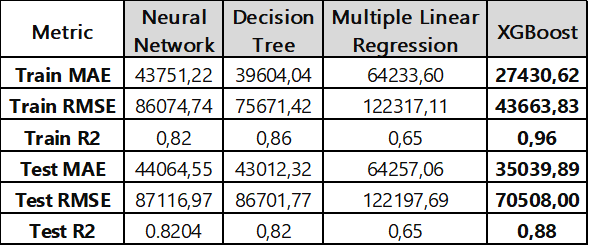[image.png]

## Random Forest

In [59]:
param_distributions = {
    'n_estimators': [100, 200],
    'criterion': ['squared_error'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'bootstrap': [True]
}

In [60]:
rf_model = RandomForestRegressor(random_state=42)

In [61]:
random_search = RandomizedSearchCV(estimator=rf_model,
                                   param_distributions=param_distributions,
                                   n_iter=20,
                                   cv=2, 
                                   scoring='neg_mean_absolute_error',
                                   verbose=2,
                                   n_jobs=-1,
                                   random_state=42)

In [62]:
random_search.fit(X_train_scaled, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['squared_error'],
                                        'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 5],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [100, 200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [63]:
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'squared_error', 'bootstrap': True}


In [73]:
def evaluate_model(X, y, model):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return mae, rmse, r2

In [74]:
#Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'squared_error', 'bootstrap': True}
model_params_RF = {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'squared_error', 'bootstrap': True}

In [75]:
def run_model_RF(X, y):
    model = RandomForestRegressor(random_state=42, **model_params_RF)
    model.fit(X, y)
    return model

In [76]:
kf = KFold(n_splits=10)

In [77]:
def avg_score_RF(method, X, y):
    mae_train_list = []
    rmse_train_list = []
    r2_train_list = []

    mae_test_list = []
    rmse_test_list = []
    r2_test_list = []

    for train_index, test_index in method.split(X):
        X_train_scaled, X_test_scaled = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Run model function
        model = run_model_RF(X_train_scaled, y_train)

        # Evaluate model function for training data
        mae_train, rmse_train, r2_train = evaluate_model(X_train_scaled, y_train, model)

        # Evaluate model function for test data
        mae_test, rmse_test, r2_test = evaluate_model(X_test_scaled, y_test, model)

        mae_train_list.append(mae_train)
        rmse_train_list.append(rmse_train)
        r2_train_list.append(r2_train)

        mae_test_list.append(mae_test)
        rmse_test_list.append(rmse_test)
        r2_test_list.append(r2_test)

    print('Train MAE:', np.mean(mae_train_list))
    print('Train RMSE:', np.mean(rmse_train_list))
    print('Train R2:', np.mean(r2_train_list))

    print('Test MAE:', np.mean(mae_test_list))
    print('Test RMSE:', np.mean(rmse_test_list))
    print('Test R2:', np.mean(r2_test_list))

In [78]:
avg_score_RF(kf, X_train_scaled, y_train)

Train MAE: 17671.254248884023
Train RMSE: 32531.9625300539
Train R2: 0.9750017043438811
Test MAE: 35479.35099946167
Test RMSE: 73391.78955617252
Test R2: 0.8722946186292304


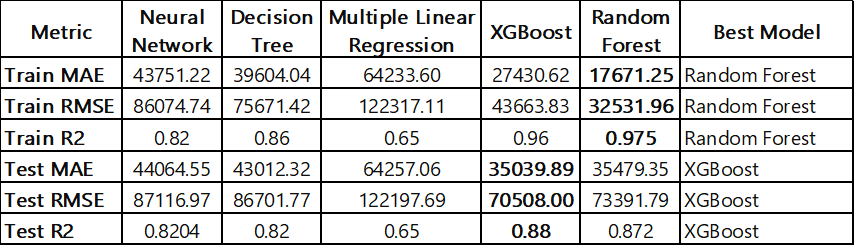